In [1]:
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 86.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.3 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR

In [3]:
!nvidia-smi

Sat Aug 10 06:31:54 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             25W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

if device == "cuda":
    num_workers = torch.cuda.device_count() * 4

In [6]:
sample_file = "/kaggle/input/cityscape-segmentation-dataset/images_prepped_train-20230811T065243Z-001/images_prepped_train/0001TP_006690.png"
with Image.open(sample_file) as im:
  width, height = im.size

In [7]:
print(width, height)

480 360


In [8]:
train_img_path = "/kaggle/input/cityscape-segmentation-dataset/images_prepped_train-20230811T065243Z-001/images_prepped_train"
train_mask_path = "/kaggle/input/cityscape-segmentation-dataset/annotations_prepped_train-20230811T065240Z-001/annotations_prepped_train"
train_img = os.listdir(train_img_path)
train_img = [img for img in train_img if img in os.listdir(train_mask_path)]
test_img_path = "/kaggle/input/cityscape-segmentation-dataset/images_prepped_test-20230811T065241Z-001/images_prepped_test"
test_mask_path = "/kaggle/input/cityscape-segmentation-dataset/annotations_prepped_test-20230811T065240Z-001/annotations_prepped_test"
test_img = os.listdir(test_img_path)
test_img = [img for img in test_img if img in os.listdir(test_mask_path)]
generator = torch.Generator().manual_seed(seed)
train_img, val_img = random_split(train_img, [0.8, 0.2], generator=generator)

In [9]:
classes = set()

for mask in train_img:
    mask_image = Image.open(os.path.join(train_mask_path, mask)).convert('L')
    mask_array = np.array(mask_image)
    unique_classes = np.unique(mask_array)
    classes.update(unique_classes)
    
temp = np.zeros(len(classes))
    
for mask in train_img:
    mask_image = Image.open(os.path.join(train_mask_path, mask)).convert('L')
    mask_array = np.array(mask_image)
    for cl in classes:
        count = np.sum(mask_array == cl)
        temp[cl] += count

# temp = temp/np.sum(temp)
# inv_weights = 1/temp
# weights = torch.from_numpy(inv_weights / np.sum(inv_weights))

print(classes)
print(temp)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}
[ 8583009. 11588242.   496986. 16041237.  2320089.  5080173.   584689.
   618696.  2991160.   326862.   157878.  2014179.]


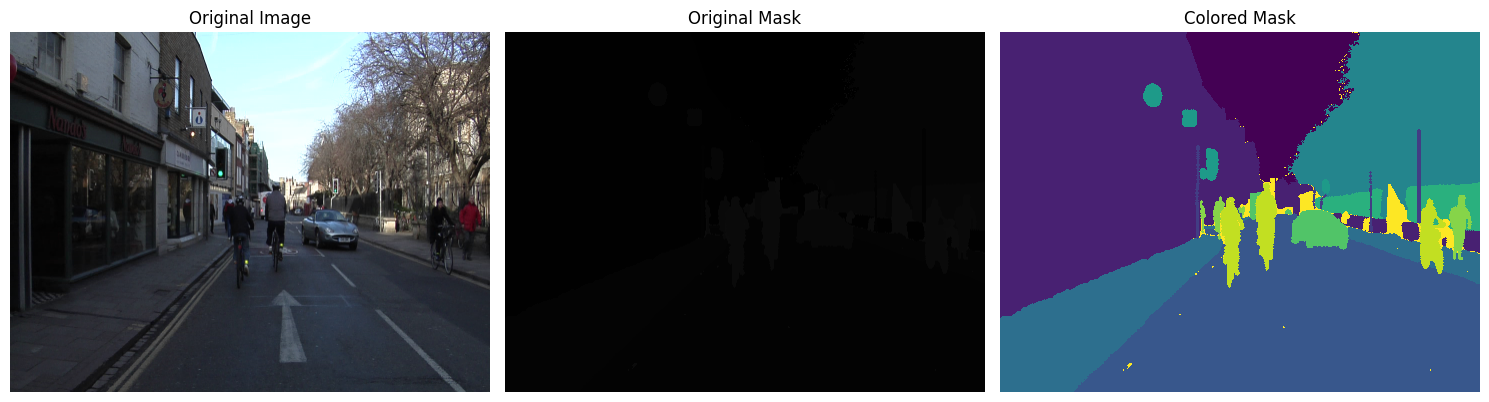

In [10]:
plt.figure(figsize=(15, 30))

sample_img = Image.open(os.path.join(test_img_path, test_img[10]))
plt.subplot(1,3,1)
plt.title("Original Image")
plt.imshow(sample_img)
plt.axis('off')

sample_mask = Image.open(os.path.join(test_mask_path, test_img[10]))
plt.subplot(1,3,2)
plt.title("Original Mask")
plt.imshow(sample_mask, cmap='gray', vmin=0, vmax=255)
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Colored Mask")
plt.imshow(sample_mask)
plt.axis('off')

plt.tight_layout()
plt.show()

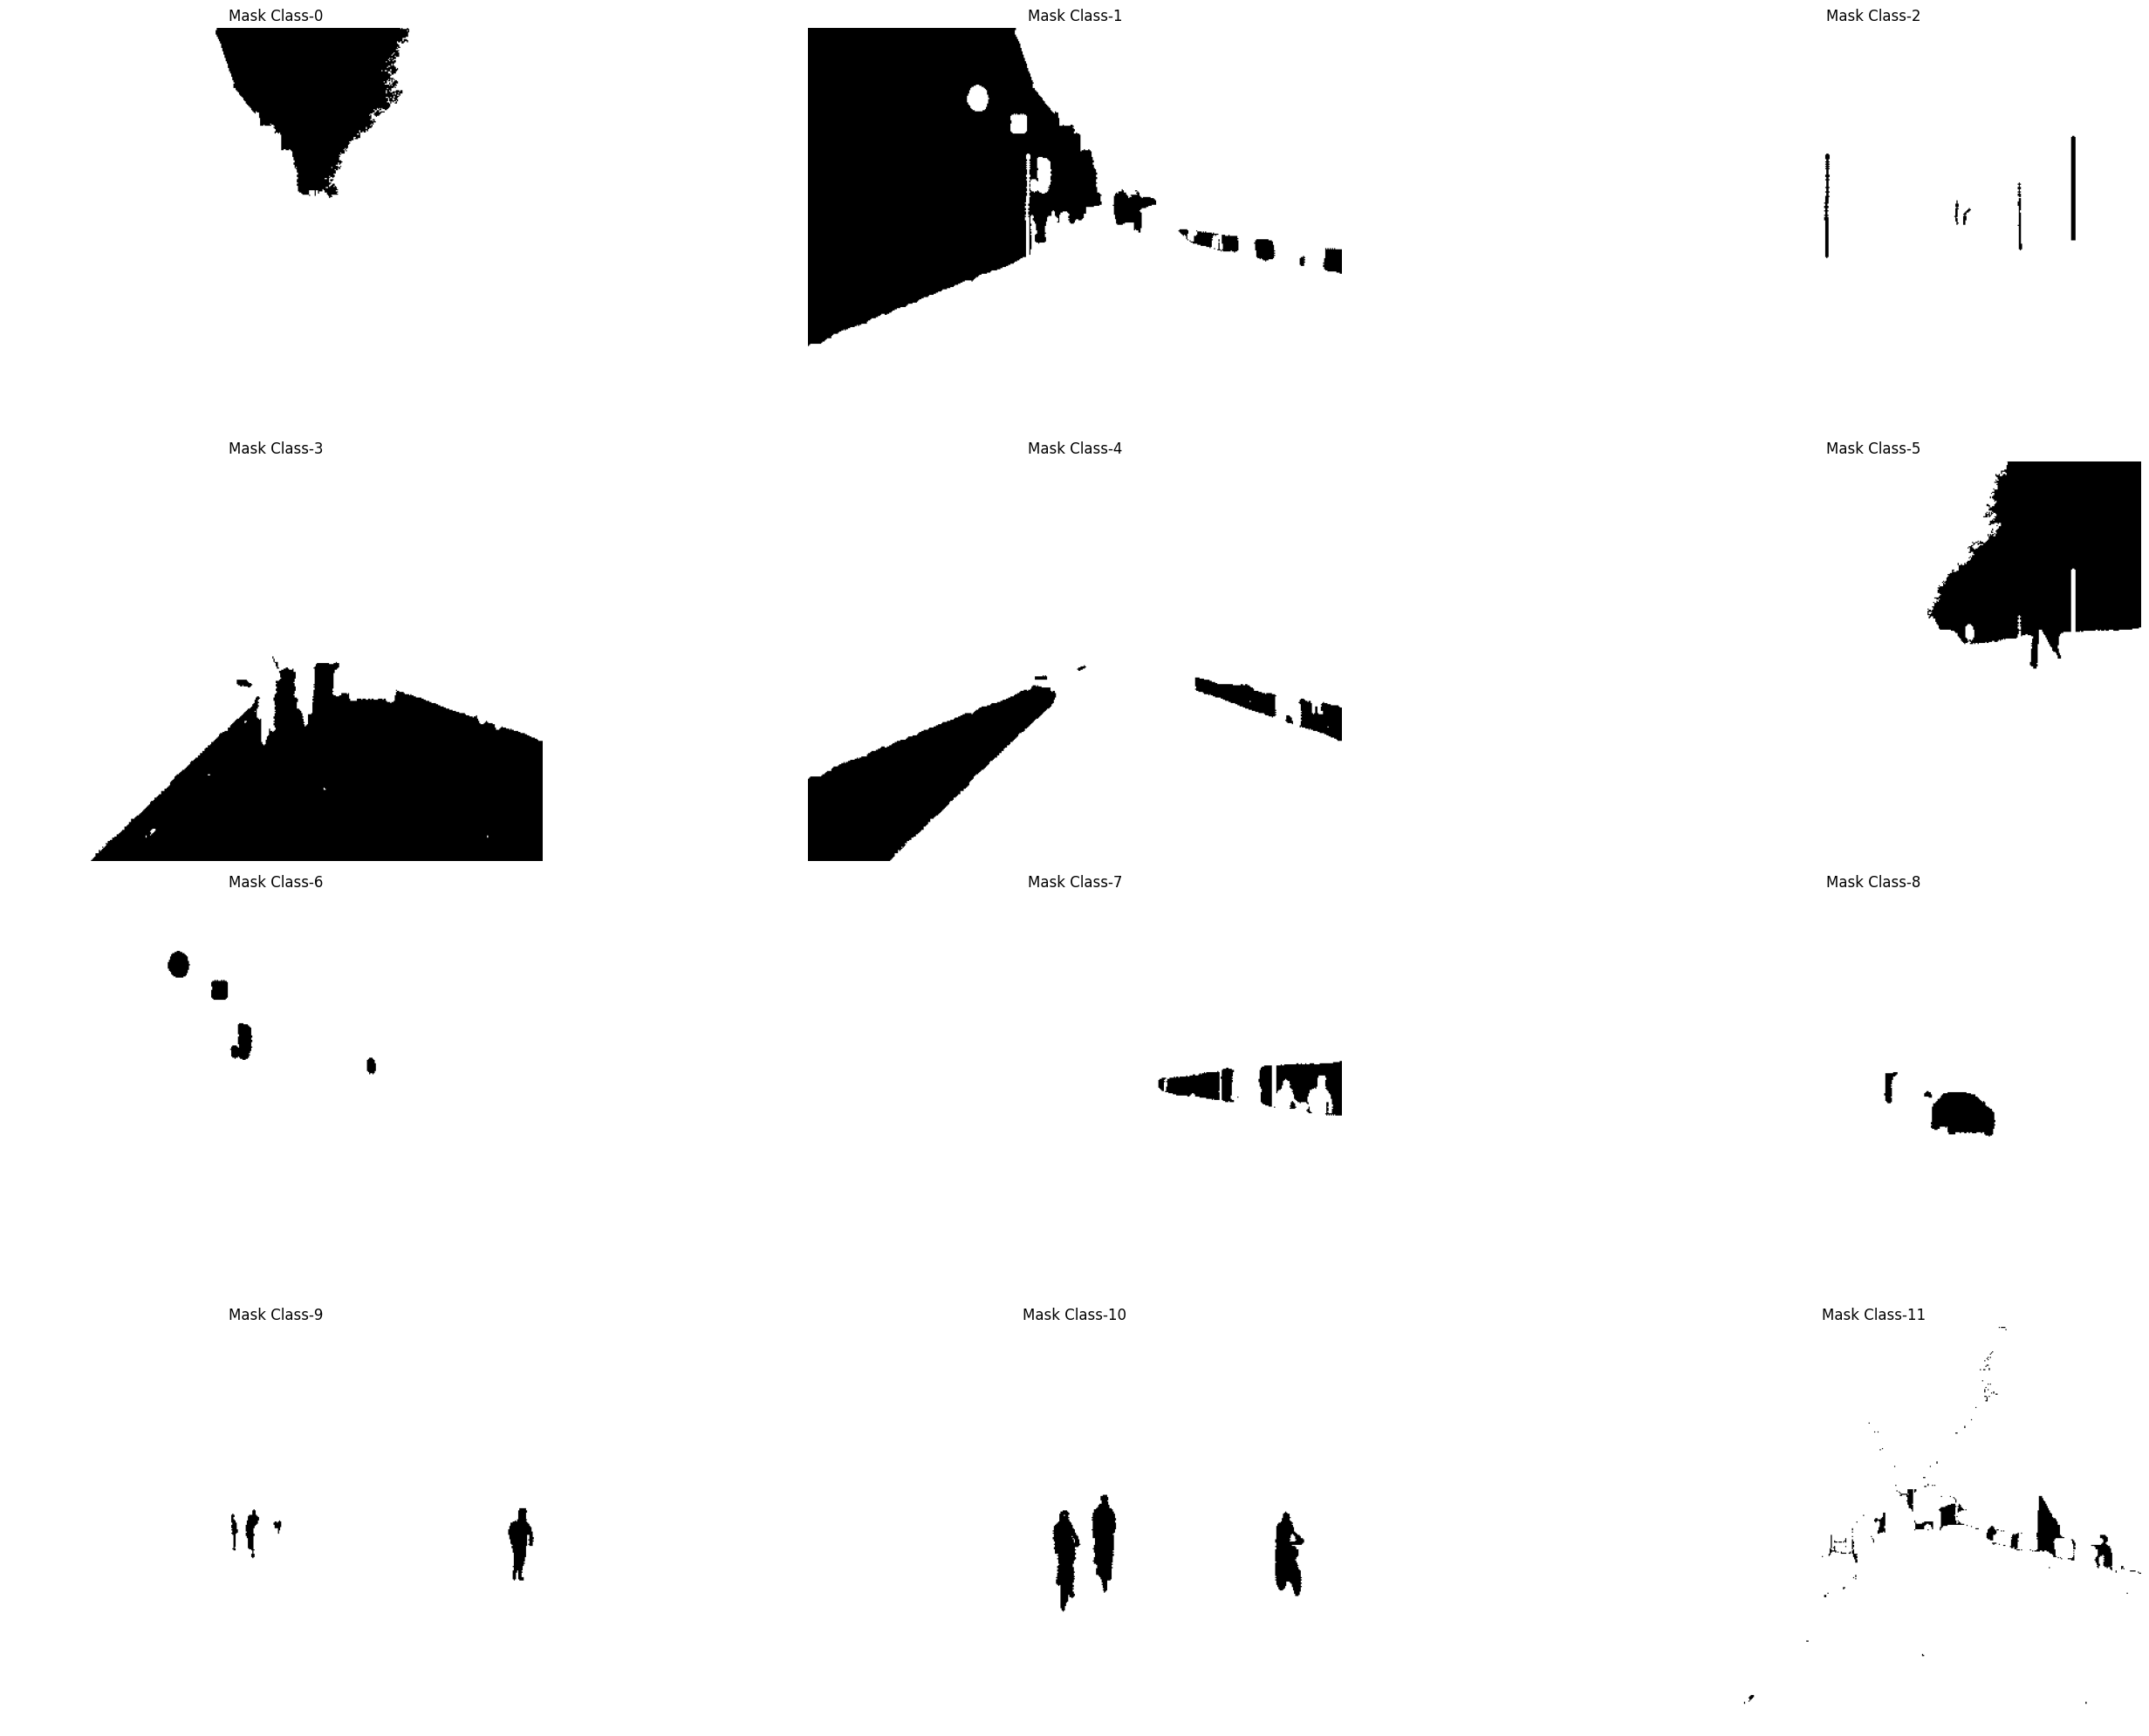

In [11]:
array = np.array(sample_mask)
plt.figure(figsize=(30, 20))
for i in classes:
    modified_array = np.where(array == i, 0, 1)
    image = Image.fromarray(modified_array.astype('uint8'))
    plt.subplot(4,3,i+1)
    plt.title(f"Mask Class-{i}")
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [12]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.conv(x)
    
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)
        return down, p
    
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x, skip):
        up = self.up(x)
        cat = torch.cat([up, skip], 1)
        return self.conv(cat)
        
class UNET(nn.Module):
    def __init__(self, in_channels, num_classes=1):
        super().__init__()
        self.down1 = DownSample(in_channels, 64)
        self.down2 = DownSample(64, 128)
        self.down3 = DownSample(128, 256)
        self.down4 = DownSample(256, 512)
        self.bottleneck = DoubleConv(512, 1024)
        self.up1 = UpSample(1024, 512)
        self.up2 = UpSample(512, 256)
        self.up3 = UpSample(256, 128)
        self.up4 = UpSample(128, 64)
        
        self.out = nn.Conv2d(64, num_classes, kernel_size=1)
    
    def forward(self, x):
        down1, p1 = self.down1(x)
        down2, p2 = self.down2(p1)
        down3, p3 = self.down3(p2)
        down4, p4 = self.down4(p3)
        
        p5 = self.bottleneck(p4)
        
        p6 = self.up1(p5, down4)
        p7 = self.up2(p6, down3)
        p8 = self.up3(p7, down2)
        p9 = self.up4(p8, down1)
        
        return self.out(p9)

In [13]:
def train_model(dataloaders, dataset_sizes, model, optimizer, criterion, scheduler=None, epochs=10):
    train_losses = []
    val_losses = []
    train_diceloss = []
    val_diceloss = []
    for epoch in tqdm(range(epochs)):
        train_running_loss = 0
        val_running_loss = 0
        train_running_dice = 0
        val_running_dice = 0
        for inputs, mask in dataloaders["train"]:
            inputs, mask = inputs.to(device), mask.to(device)
            mask = mask.squeeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, mask.long())
            loss.backward()
            optimizer.step()
            train_running_loss += loss.item()
        
        train_losses.append(train_running_loss/len(dataloaders["train"]))
        
        with torch.no_grad():
            for inputs, mask in dataloaders["validation"]:
                inputs, mask = inputs.to(device), mask.to(device)
                mask = mask.squeeze(1)
                outputs = model(inputs)
                loss = criterion(outputs, mask.long())
                val_running_loss += loss.item()
                
            val_losses.append(val_running_loss/len(dataloaders["validation"]))
        
        scheduler.step(val_running_dice/len(dataloaders["validation"]))
            
        print(f'Epoch-{epoch+1}/{epochs}')
        print(f'Training Losses: {train_running_loss/len(dataloaders["train"])}')
        print(f'Validation Losses: {val_running_loss/len(dataloaders["validation"])}')
    
    return train_losses, val_losses

In [14]:
class Dataset(Dataset):
    def __init__(self, img, image_folder_path, mask_folder_path, transform=None):
        self.img_list = img
        self.image_folder_path = image_folder_path
        self.mask_folder_path = mask_folder_path
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        image_path = [os.path.join(self.image_folder_path, img) for img in self.img_list]
        mask_path = [os.path.join(self.mask_folder_path, img) for img in self.img_list]

        image = Image.open(image_path[idx])
        mask = Image.open(mask_path[idx])
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        image = transforms.ToTensor()(image)
        mask_np = np.array(mask)
        mask = torch.tensor(mask_np, dtype=torch.long)

        return image, mask

In [15]:
transform = {
    'train': transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomRotation(degrees=(-15, 15)),
    transforms.RandomPerspective(distortion_scale=0.4, p=0.2),
    transforms.Resize((512,512)),
    ]),
    'val': transforms.Compose([
    transforms.Resize((512,512)),
    ]),
    'test': transforms.Compose([
    transforms.Resize((512,512)),
    ])
}

In [16]:
train_set = Dataset(train_img, image_folder_path=train_img_path, mask_folder_path=train_mask_path, transform=transform['train'])
train_loader = DataLoader(train_set, batch_size=4, shuffle=True)

val_set = Dataset(val_img, image_folder_path=train_img_path, mask_folder_path=train_mask_path, transform=transform['val'])
val_loader = DataLoader(val_set, batch_size=4, shuffle=True)

test_set = Dataset(test_img, image_folder_path=test_img_path, mask_folder_path=test_mask_path, transform=transform['test'])
test_loader = DataLoader(test_set, batch_size=4, shuffle=True)

dataloaders = {
    "train":train_loader, "validation":val_loader, "test":test_loader
}
dataset_sizes= {
    "train":len(train_set), "validation":len(val_set), "test":len(test_set)
}

In [17]:
def init_weights(m):
    if isinstance(m, (nn.Conv2d,nn.ConvTranspose2d)):
        nn.init.kaiming_uniform_(m.weight, mode="fan_in", nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
            
model = UNET(in_channels=3, num_classes=12).to(device)
model.apply(init_weights)
optimizer = optim.AdamW(model.parameters(), lr=1e-2)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=10, threshold_mode='abs', verbose=True)
criterion = nn.CrossEntropyLoss()
model

UNET(
  (down1): DownSample(
    (conv): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down2): DownSample(
    (conv): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum

In [45]:
train_losses, val_losses = train_model(dataloaders, dataset_sizes, model=model, optimizer=optimizer, criterion=criterion, scheduler=scheduler, epochs=50)
torch.save({
            'epoch': 50,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, "/kaggle/working/UNET_CityScape.pt")
df = pd.DataFrame({'train_losses': train_losses, 'val_losses': val_losses})
df.to_csv("/kaggle/working/UNET_CityScape_Loss.csv")

  2%|▏         | 1/50 [00:59<48:43, 59.66s/it]

Epoch-1/50
Training Losses: 1.6742185241467245
Validation Losses: 1.4209904168781482


  4%|▍         | 2/50 [01:59<47:41, 59.62s/it]

Epoch-2/50
Training Losses: 1.4897988277512628
Validation Losses: 1.2835357628370587


  6%|▌         | 3/50 [02:58<46:37, 59.53s/it]

Epoch-3/50
Training Losses: 1.4449293468449567
Validation Losses: 1.2699400939439471


  8%|▊         | 4/50 [03:58<45:35, 59.47s/it]

Epoch-4/50
Training Losses: 1.3835853998725478
Validation Losses: 1.2111413949414302


 10%|█         | 5/50 [04:57<44:36, 59.48s/it]

Epoch-5/50
Training Losses: 1.3435806261526573
Validation Losses: 1.1613797325836985


 12%|█▏        | 6/50 [05:56<43:35, 59.44s/it]

Epoch-6/50
Training Losses: 1.3694658617715578
Validation Losses: 1.2104399235625016


 14%|█▍        | 7/50 [06:56<42:36, 59.45s/it]

Epoch-7/50
Training Losses: 1.361188348886129
Validation Losses: 1.2968820207997371


 16%|█▌        | 8/50 [07:55<41:37, 59.47s/it]

Epoch-8/50
Training Losses: 1.3394604486388129
Validation Losses: 1.1847638707411916


 18%|█▊        | 9/50 [08:55<40:39, 59.49s/it]

Epoch-9/50
Training Losses: 1.333331356177459
Validation Losses: 1.2049556092212075


 20%|██        | 10/50 [09:54<39:39, 59.48s/it]

Epoch-10/50
Training Losses: 1.3202225420926068
Validation Losses: 1.0972037033030861


 22%|██▏       | 11/50 [10:54<38:39, 59.48s/it]

Epoch-11/50
Training Losses: 1.3114043264775663
Validation Losses: 1.141322368069699


 24%|██▍       | 12/50 [11:53<37:39, 59.45s/it]

Epoch 00012: reducing learning rate of group 0 to 5.0000e-03.
Epoch-12/50
Training Losses: 1.3088719603177663
Validation Losses: 1.1992161587664956


 26%|██▌       | 13/50 [12:53<36:40, 59.47s/it]

Epoch-13/50
Training Losses: 1.26963833377168
Validation Losses: 1.1191856610147577


 28%|██▊       | 14/50 [13:52<35:40, 59.46s/it]

Epoch-14/50
Training Losses: 1.2596706554696366
Validation Losses: 1.096686680065958


 30%|███       | 15/50 [14:52<34:41, 59.48s/it]

Epoch-15/50
Training Losses: 1.2732041800344311
Validation Losses: 1.0973884745648033


 32%|███▏      | 16/50 [15:51<33:40, 59.43s/it]

Epoch-16/50
Training Losses: 1.2460505317997288
Validation Losses: 1.110368665895964


 34%|███▍      | 17/50 [16:50<32:41, 59.43s/it]

Epoch-17/50
Training Losses: 1.2710009523340173
Validation Losses: 1.1186894743066085


 36%|███▌      | 18/50 [17:50<31:41, 59.43s/it]

Epoch-18/50
Training Losses: 1.2719629261944745
Validation Losses: 1.136859931443867


 38%|███▊      | 19/50 [18:49<30:42, 59.43s/it]

Epoch-19/50
Training Losses: 1.2614394281361554
Validation Losses: 1.1042591772581403


 40%|████      | 20/50 [19:49<29:42, 59.42s/it]

Epoch-20/50
Training Losses: 1.264355256750777
Validation Losses: 1.104466438293457


 42%|████▏     | 21/50 [20:48<28:43, 59.44s/it]

Epoch-21/50
Training Losses: 1.2578613548665434
Validation Losses: 1.0771403626391762


 44%|████▍     | 22/50 [21:48<27:43, 59.42s/it]

Epoch-22/50
Training Losses: 1.2402508452131942
Validation Losses: 1.0129558036201878


 46%|████▌     | 23/50 [22:47<26:45, 59.45s/it]

Epoch 00023: reducing learning rate of group 0 to 2.5000e-03.
Epoch-23/50
Training Losses: 1.2593995896545616
Validation Losses: 1.066139767044469


 48%|████▊     | 24/50 [23:47<25:47, 59.52s/it]

Epoch-24/50
Training Losses: 1.251537728954006
Validation Losses: 1.0596903625287508


 50%|█████     | 25/50 [24:46<24:46, 59.48s/it]

Epoch-25/50
Training Losses: 1.2221314810417794
Validation Losses: 1.0637896907956976


 52%|█████▏    | 26/50 [25:45<23:46, 59.43s/it]

Epoch-26/50
Training Losses: 1.243263579703666
Validation Losses: 1.1206192405600297


 54%|█████▍    | 27/50 [26:45<22:46, 59.41s/it]

Epoch-27/50
Training Losses: 1.238290520938667
Validation Losses: 1.0506088765043962


 56%|█████▌    | 28/50 [27:44<21:46, 59.39s/it]

Epoch-28/50
Training Losses: 1.1946665040544562
Validation Losses: 1.0397944544491016


 58%|█████▊    | 29/50 [28:44<20:47, 59.40s/it]

Epoch-29/50
Training Losses: 1.2166397201048362
Validation Losses: 0.9996379958955866


 60%|██████    | 30/50 [29:43<19:48, 59.42s/it]

Epoch-30/50
Training Losses: 1.2153355519513827
Validation Losses: 1.032618036395625


 62%|██████▏   | 31/50 [30:42<18:48, 59.41s/it]

Epoch-31/50
Training Losses: 1.2200855636918866
Validation Losses: 1.0480030806441056


 64%|██████▍   | 32/50 [31:42<17:49, 59.42s/it]

Epoch-32/50
Training Losses: 1.2020158260255247
Validation Losses: 0.9802369287139491


 66%|██████▌   | 33/50 [32:41<16:50, 59.44s/it]

Epoch-33/50
Training Losses: 1.2207965222564903
Validation Losses: 1.0605701302227222


 68%|██████▊   | 34/50 [33:41<15:50, 59.40s/it]

Epoch 00034: reducing learning rate of group 0 to 1.2500e-03.
Epoch-34/50
Training Losses: 1.2030992749575022
Validation Losses: 1.0118936394390308


 70%|███████   | 35/50 [34:40<14:51, 59.41s/it]

Epoch-35/50
Training Losses: 1.1966925013709713
Validation Losses: 0.9686706536694577


 72%|███████▏  | 36/50 [35:40<13:51, 59.42s/it]

Epoch-36/50
Training Losses: 1.2031569295638316
Validation Losses: 0.9847268054359838


 74%|███████▍  | 37/50 [36:39<12:52, 59.40s/it]

Epoch-37/50
Training Losses: 1.195544094652743
Validation Losses: 1.018073370582179


 76%|███████▌  | 38/50 [37:38<11:52, 59.38s/it]

Epoch-38/50
Training Losses: 1.186980618012918
Validation Losses: 1.0031333408857648


 78%|███████▊  | 39/50 [38:38<10:53, 59.38s/it]

Epoch-39/50
Training Losses: 1.1922427109769873
Validation Losses: 0.9854685350468284


 80%|████████  | 40/50 [39:37<09:54, 59.40s/it]

Epoch-40/50
Training Losses: 1.1987746728433144
Validation Losses: 1.004862528098257


 82%|████████▏ | 41/50 [40:36<08:54, 59.39s/it]

Epoch-41/50
Training Losses: 1.1792476869918205
Validation Losses: 0.9969733859363356


 84%|████████▍ | 42/50 [41:36<07:55, 59.41s/it]

Epoch-42/50
Training Losses: 1.1842266063432436
Validation Losses: 0.9909598450911673


 86%|████████▌ | 43/50 [42:35<06:55, 59.39s/it]

Epoch-43/50
Training Losses: 1.2051407936457041
Validation Losses: 1.0157265569034375


 88%|████████▊ | 44/50 [43:35<05:56, 59.39s/it]

Epoch-44/50
Training Losses: 1.1849480126355145
Validation Losses: 0.9986078268603275


 90%|█████████ | 45/50 [44:34<04:56, 59.39s/it]

Epoch 00045: reducing learning rate of group 0 to 6.2500e-04.
Epoch-45/50
Training Losses: 1.2064236201144554
Validation Losses: 1.0153896087094356


 92%|█████████▏| 46/50 [45:33<03:57, 59.36s/it]

Epoch-46/50
Training Losses: 1.1980461381577157
Validation Losses: 0.9797692330260026


 94%|█████████▍| 47/50 [46:33<02:58, 59.35s/it]

Epoch-47/50
Training Losses: 1.171508116496576
Validation Losses: 0.9685748721423902


 96%|█████████▌| 48/50 [47:32<01:58, 59.33s/it]

Epoch-48/50
Training Losses: 1.1680678008375942
Validation Losses: 0.9793726519534462


 98%|█████████▊| 49/50 [48:31<00:59, 59.37s/it]

Epoch-49/50
Training Losses: 1.1663937149821102
Validation Losses: 0.9689000311650728


100%|██████████| 50/50 [49:31<00:00, 59.43s/it]

Epoch-50/50
Training Losses: 1.1718801380814732
Validation Losses: 0.9820053075489245


In [19]:
checkpoint = torch.load("/kaggle/input/unet-cityscape-training-checkpoint/UNET_CityScape (1).pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# train_losses2, val_losses2 = train_model(dataloaders, dataset_sizes, model=model, optimizer=optimizer, criterion=criterion, scheduler=scheduler, epochs=50)
# torch.save({
#             'epoch': 100,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             }, "/kaggle/working/UNet_CityScape2.pt")
# torch.save(model.state_dict(), "/kaggle/working/UNet_CityScape.pth")
# df = pd.DataFrame({'train_losses': train_losses2, 'val_losses': val_losses2})
# df.to_csv("/kaggle/working/UNet_CityScape_Loss2.csv")

In [20]:
import torch.onnx

input_names = ["input"]
output_names = ["output"]
dummy_input = torch.rand(1, 3, 512, 512).to(device)
dynamic_axes = {'input': {0: 'batch_size', 2: 'width', 3: 'height'},
 'output': {0: 'batch_size', 2: 'width', 3: 'height'}} # adding names for better debugging

torch.onnx.export(
    model,
    dummy_input,
    "/kaggle/working/UNet_CityScape.onnx",
    verbose=True,
    input_names=input_names, # the model's input names
    output_names=output_names, # the model's output names
    dynamic_axes=dynamic_axes,
    opset_version=14, # the ONNX version to export the model to
    do_constant_folding=True, # whether to execute constant folding for optimization
)

Exported graph: graph(%input : Float(*, 3, *, *, strides=[786432, 262144, 512, 1], requires_grad=0, device=cuda:0),
      %up1.up.weight : Float(1024, 512, 2, 2, strides=[2048, 4, 2, 1], requires_grad=1, device=cuda:0),
      %up1.up.bias : Float(512, strides=[1], requires_grad=1, device=cuda:0),
      %up2.up.weight : Float(512, 256, 2, 2, strides=[1024, 4, 2, 1], requires_grad=1, device=cuda:0),
      %up2.up.bias : Float(256, strides=[1], requires_grad=1, device=cuda:0),
      %up3.up.weight : Float(256, 128, 2, 2, strides=[512, 4, 2, 1], requires_grad=1, device=cuda:0),
      %up3.up.bias : Float(128, strides=[1], requires_grad=1, device=cuda:0),
      %up4.up.weight : Float(128, 64, 2, 2, strides=[256, 4, 2, 1], requires_grad=1, device=cuda:0),
      %up4.up.bias : Float(64, strides=[1], requires_grad=1, device=cuda:0),
      %out.weight : Float(12, 64, 1, 1, strides=[64, 1, 1, 1], requires_grad=1, device=cuda:0),
      %out.bias : Float(12, strides=[1], requires_grad=1, device=cu

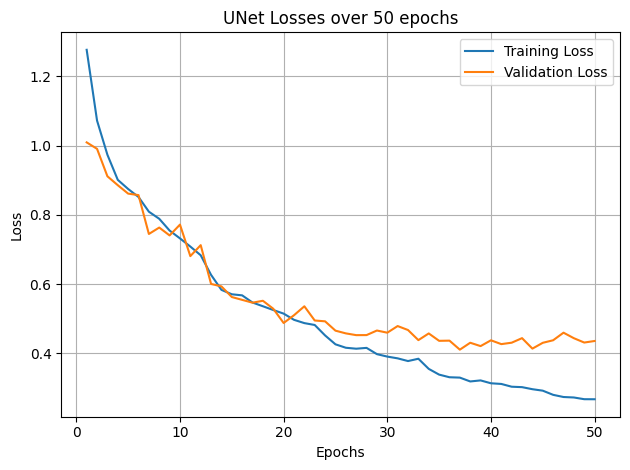

In [21]:
df = pd.read_csv('/kaggle/input/unet-cityscape-training-checkpoint/UNET_CityScape_Loss (1).csv', delimiter=",")  #for further training
train_losses = df.iloc[:,1].values
val_losses = df.iloc[:,2].values  


for i, j in enumerate(val_losses):
    if j>1.4:  #1.4 is maximum acceptable loss based on curve observation
        val_losses[i] = (val_losses[i-1]+val_losses[i+1])/2  #To Eliminate Exploding Loss

plt.plot(np.linspace(1,50,50), train_losses, label='Training Loss')
plt.plot(np.linspace(1,50,50), val_losses, label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('UNet Losses over 50 epochs')
plt.grid()
plt.tight_layout()

plt.legend()
plt.show()

In [22]:
def check_accuracy(loader, model, num_classes):
    num_correct = 0
    num_pixels = 0
    dice_score = 0.0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            outputs = model(x)
            preds = torch.argmax(outputs, dim=1)

            num_correct += (preds == y).sum().item()
            num_pixels += torch.numel(preds)

            dice_score_batch = 0.0
            for cls in range(num_classes):
                preds_cls = (preds == cls).float()
                y_cls = (y == cls).float()

                intersection = (preds_cls * y_cls).sum().item()
                dice_score_batch += (2.0 * intersection) / (preds_cls.sum().item() + y_cls.sum().item() + 1e-8)

            dice_score += dice_score_batch / num_classes

    print(f"Got {num_correct}/{num_pixels} with acc {num_correct / num_pixels * 100:.2f}")
    print(f"Dice score: {dice_score / len(loader):.4f}")

In [24]:
check_accuracy(dataloaders['test'], model, len(classes))

Got 22713907/26476544 with acc 85.79
Dice score: 0.5819


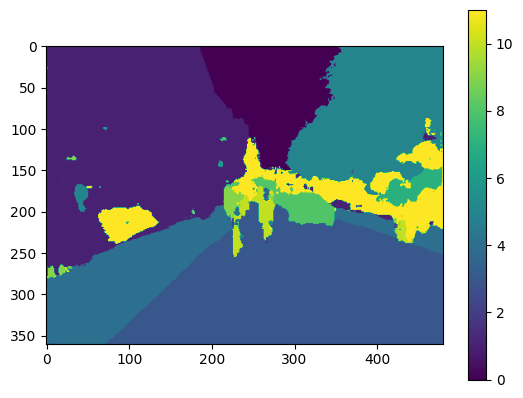

Inference Time: 2.819899509999914s
Detected Objects:
sky
building
pole
road
sidewalk
nature
sign
fence
car
person
rider
bicycle


In [28]:
import time

model.to('cpu')
model.eval()
trf = transform['test']
test_im = Image.open(os.path.join(test_img_path, test_img[10]))
img = transforms.ToTensor()(trf(test_im))
plt.imshow(test_im)
inputs = img.unsqueeze(0)

with torch.no_grad():
    start_time = time.perf_counter()
    outputs = model(inputs)
    inf_time = time.perf_counter() - start_time
    outputs = nn.Softmax2d()(outputs)
    
pred_labels = torch.argmax(outputs, dim=1) 
pred_labels = pred_labels.int()
pred_labels = pred_labels.squeeze()
pred_labels_pil = transforms.ToPILImage()(pred_labels).convert('L')
resize = transforms.Resize((height, width), interpolation=Image.NEAREST)
resized_img = resize(pred_labels_pil)

plt.imshow(resized_img, vmin=0, vmax=11)
plt.colorbar()
plt.show()
print(f"Inference Time: {inf_time}s")

det_classes = set()
obj = {
    0:"sky",
    1:"building",
    2:"pole",
    3:"road",
    4:"sidewalk",
    5:"nature",
    6:"sign",
    7:"fence",
    8:"car",
    9:"person",
    10:"rider",
    11:"bicycle"
}

for mask in train_img:
    mask_image = Image.open(os.path.join(train_mask_path, mask)).convert('L')
    mask_array = np.array(mask_image)
    unique_classes = np.unique(mask_array)
    det_classes.update(unique_classes)

print("Detected Objects:")
for key in obj:
    if key in det_classes:
        print(f"{obj[key]}")

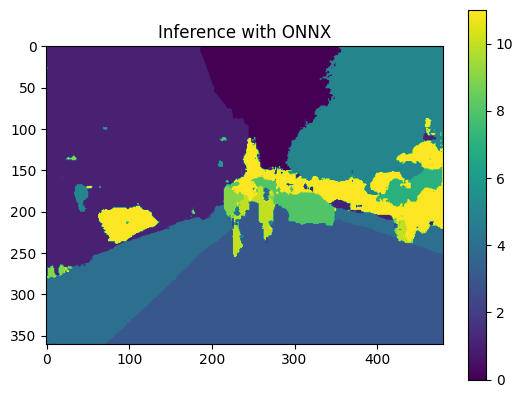

Inference Time: 1.7032392139999502s


In [29]:
import onnxruntime

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

test_im = Image.open(os.path.join(test_img_path, test_img[10]))
img = transforms.ToTensor()(trf(test_im))
img = img.unsqueeze(0)

ort_session = onnxruntime.InferenceSession("/kaggle/input/unet-cityscape-training-checkpoint/UNet_CityScape.onnx", providers=["CPUExecutionProvider"])
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(img)}
start_time = time.perf_counter()
ort_outs = ort_session.run(None, ort_inputs)
inf_time = time.perf_counter() - start_time

out = np.squeeze(np.array(ort_outs))

pred_labels = np.uint8(np.argmax(out, axis=0))
pred_labels_pil = transforms.ToPILImage()(pred_labels).convert('L')
resize = transforms.Resize((height, width), interpolation=Image.NEAREST)
resized_img = resize(pred_labels_pil)

plt.imshow(resized_img, vmin=0, vmax=11)
plt.colorbar()
plt.title("Inference with ONNX")
plt.show()
print(f"Inference Time: {inf_time}s")

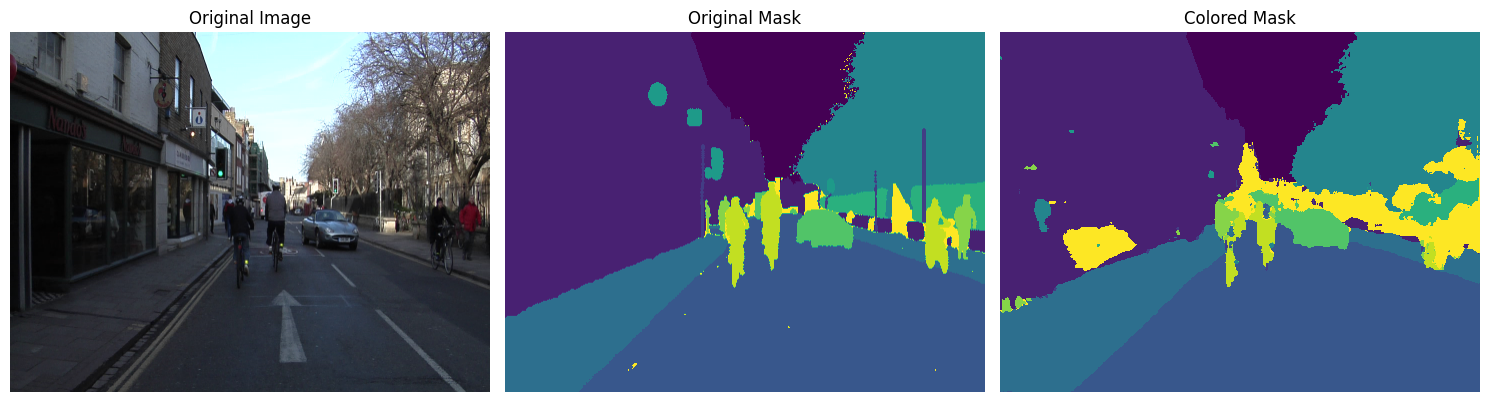

In [30]:
plt.figure(figsize=(15, 30))

sample_img = Image.open(os.path.join(test_img_path, test_img[10]))
plt.subplot(1,3,1)
plt.title("Original Image")
plt.imshow(sample_img)
plt.axis('off')

sample_mask = Image.open(os.path.join(test_mask_path, test_img[10]))
plt.subplot(1,3,2)
plt.title("Original Mask")
plt.imshow(sample_mask)
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Colored Mask")
plt.imshow(resized_img, vmin=0, vmax=11)
plt.axis('off')

plt.tight_layout()
plt.show()